In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from model import *

unlabel_prob = 0.95 # probability of labels to be unlabeled
percentile = 90     # when a graph is not given, construct a graph 
                    # dropping nodes under this percentile 

iris = False        # use iris data
hard = False
sigma = 3           # sigma hyperparameter for RBF kernel

%matplotlib inline

### Get Data

In [2]:
if iris:
    true_labels, features, graph = Data.Data.load_iris()
else:
    true_labels, features, graph = Data.Data.load_cora()

In [3]:
labels, is_labeled, labeled_indices, unlabeled_indices = utils.random_unlabel(true_labels,unlabel_prob=unlabel_prob,hard=hard)
solution  = true_labels[unlabeled_indices]
weights   = utils.rbf_kernel(features,s=sigma,G=graph,percentile=percentile)
num_nodes = len(labels)
data, validation_data = Data.Data.prepare(labels,labeled_indices,true_labels)

In [4]:
baseline_prediction = np.rint(labels[unlabeled_indices])
print("[Baseline]　Accuracy:", utils.accuracy(solution, baseline_prediction), 
      "RMSE:", utils.rmse(solution, baseline_prediction))

[Baseline]　Accuracy: 0.706355932203 RMSE: 0.293644067797


### Label Propagation

In [5]:
lp = LP.LP()
lp_closed_prediction = np.rint(lp.closed(labels,
                                  weights,
                                  labeled_indices,
                                  unlabeled_indices))
lp_iter_prediction = np.rint(lp.iter(labels,
                                  weights,
                                  labeled_indices,
                                  unlabeled_indices,
                                  num_iter=100))

In [6]:
print("[Closed]　Accuracy:", utils.accuracy(solution, lp_closed_prediction), 
      "RMSE:", utils.rmse(solution, lp_closed_prediction))
print("[Iter]　Accuracy:", utils.accuracy(solution, lp_iter_prediction), 
      "RMSE:", utils.rmse(solution, lp_iter_prediction))

[Closed]　Accuracy: 0.827542372881 RMSE: 0.172457627119
[Iter]　Accuracy: 0.845762711864 RMSE: 0.154237288136


In [8]:
for num_iter in [1,2,3,4,5,10,100,1000]:
    print(num_iter)
    lp_iter_prediction = np.rint(lp.iter(labels,
                                  weights,
                                  labeled_indices,
                                  unlabeled_indices,
                                  num_iter=num_iter))
#     print("Objective:", utils.objective(labels[labeled_indices],lp_iter_prediction,weights))
    print("Accuracy:", utils.accuracy(solution,lp_iter_prediction))
    print("RMSE:", utils.rmse(solution,lp_iter_prediction))

1
Accuracy: 0.730084745763
RMSE: 0.269915254237
2
Accuracy: 0.809322033898
RMSE: 0.190677966102
3
Accuracy: 0.841525423729
RMSE: 0.158474576271
4
Accuracy: 0.855084745763
RMSE: 0.144915254237
5
Accuracy: 0.862288135593
RMSE: 0.137711864407
10
Accuracy: 0.872881355932
RMSE: 0.127118644068
100
Accuracy: 0.866101694915
RMSE: 0.133898305085
1000
Accuracy: 0.857203389831
RMSE: 0.142796610169


### DeepLP

In [14]:
dlp = DeepLP.DeepLP(100,num_nodes,weights,0.1)
dlp_prediction = np.rint(dlp.labelprop(validation_data)).reshape(num_nodes)[unlabeled_indices]
print("[DeepLP]　Accuracy:", utils.accuracy(solution, dlp_prediction), 
      "RMSE:", utils.rmse(solution, dlp_prediction))


[DeepLP]　Accuracy: 0.489795918367 RMSE: 0.510204081633


In [ ]:
num_nodes.shape,features.shape

### DeepLP_RBF

In [16]:
dlp_rbf = DeepLP_RBF.DeepLP_RBF(100, num_nodes, features, graph, sigma, 0.1)
dlp_rbf_prediction = np.rint(dlp_rbf.labelprop(validation_data,sigma)).reshape(num_nodes)[unlabeled_indices]
print("[DeepLP]　Accuracy:", utils.accuracy(solution, dlp_rbf_prediction), 
      "RMSE:", utils.rmse(solution, dlp_rbf_prediction))

ValueError: Dimensions must be equal, but are 100 and 0 for 'mul_2' (op: 'Mul') with input shapes: [100,100], [0].

In [18]:
dlp.phi,dlp.graph

AttributeError: 'DeepLP' object has no attribute 'phi'

In [7]:
dlp_rbf.train(data,validation_data,200)

epoch: -1 labeled loss: 0.17898 unlabeled loss: 0.195812 accuracy: 0.773165 true unlabeled loss: 0.194132 true accuracy: 0.772764
--- 4.116937875747681 seconds ---
sigma: 3.0
--- 4.962007761001587 seconds ---
epoch: 0 labeled loss: 0.178935 unlabeled loss: 0.195795 accuracy: 0.773117 true unlabeled loss: 0.194116 true accuracy: 0.771951
--- 2.0138349533081055 seconds ---
sigma: 3.09993


KeyboardInterrupt: 

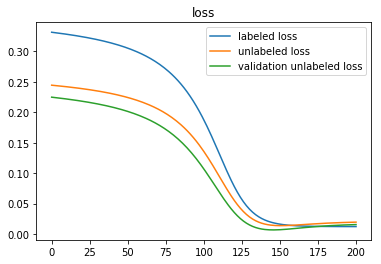

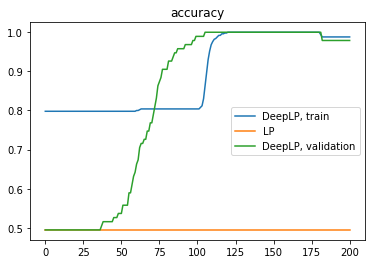

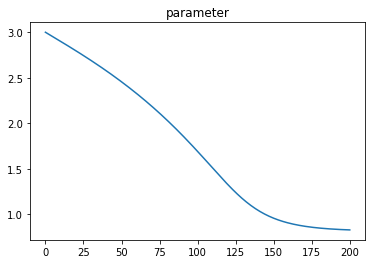

In [90]:
dlp_rbf.plot()

# DeepLP_WeightedRBF

In [8]:
theta = np.ones(features.shape[1]).reshape(1,features.shape[1])
dlp_wrbf = DeepLP_WeightedRBF.DeepLP_WeightedRBF(100, num_nodes, features, graph, sigma, theta, 1, regularize=0)
dlp_wrbf_prediction = np.rint(dlp_wrbf.labelprop(validation_data,theta)).reshape(num_nodes)[unlabeled_indices]
print("[DeepLP Weighted RBF]　Accuracy:", utils.accuracy(solution, dlp_wrbf_prediction), 
      "RMSE:", utils.rmse(solution, dlp_wrbf_prediction))

[DeepLP Weighted RBF]　Accuracy: 0.772764227642 RMSE: 0.227235772358


In [9]:
dlp_wrbf.train(data,validation_data,200)

epoch: -1 labeled loss: 0.17898 unlabeled loss: 0.195812 accuracy: 0.773165 true unlabeled loss: 0.194132 true accuracy: 0.772764
--- 4.98644495010376 seconds ---
theta: [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.]]
--- 4.636031866073608 seconds ---
epoch: 0 labeled loss: 0.175093 unlabeled loss: 0.194791 accuracy: 0.769232 true unlabeled loss: 0.193111 true accuracy: 0.769919
--- 1.9671940803527832 seconds ---
theta: [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.]]
--- 4.527286767959595 seconds ---
epoch: 1 labeled loss: 0.1735 unlabeled loss: 0.196145 accuracy: 0.771751 true unlabeled loss: 0.19451 true accuracy: 0.772358
--- 1.889951229095459 seconds ---
theta: [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.]]
--- 5.258843183517456 seconds ---
epoch: 2 labeled loss: 0.173336 unlabeled loss: 0.198559 accuracy: 0.775165 true unlabeled loss: 0.196985 true accuracy: 0.77561
--- 2.0509707

KeyboardInterrupt: 

AttributeError: 'DeepLP_WeightedRBF' object has no attribute 'unlabeled_losses'

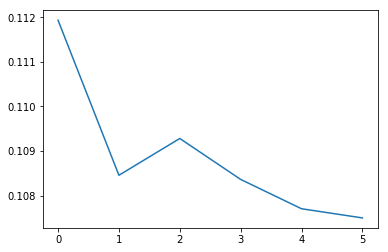

In [15]:
dlp_wrbf.plot()

In [8]:
sigmas = [i for i in np.arange(0.1,5,0.1)]

In [9]:
accuracies = []
rmses = []
for i,sigma_ in enumerate(sorted(sigmas)):
    print(i)
    if i % 50 == 0:
        print(i)
    dlp_rbf = DeepLP_RBF.DeepLP_RBF(100, num_nodes, features, graph, sigma_, 0.1)

    dlp_rbf_prediction = np.rint(dlp_rbf.labelprop(validation_data,sigma_)).reshape(num_nodes)[unlabeled_indices]
    accuracy = utils.accuracy(solution, dlp_rbf_prediction)
    rmse = utils.rmse(solution, dlp_rbf_prediction)
    accuracies.append(accuracy)
    rmses.append(rmse)
    print(sigma_)
    print(accuracies[-1])


0
0
0.1
0.0
1
0.2
0.0
2
0.3
0.763559322034
3
0.4
0.805508474576
4
0.5
0.834745762712
5
0.6
0.85
6
0.7
0.854661016949
7
0.8
0.859322033898
8
0.9
0.854661016949
9
1.0
0.854661016949
10
1.1
0.852542372881
11
1.2
0.85
12
1.3
0.847033898305
13
1.4
0.847457627119
14
1.5
0.845338983051
15
1.6
0.846186440678
16
1.7
0.847881355932
17
1.8
0.846186440678
18
1.9
0.847457627119
19
2.0
0.846186440678
20
2.1
0.845338983051
21
2.2
0.845338983051
22
2.3
0.844491525424
23
2.4
0.844491525424
24
2.5
0.844915254237
25
2.6
0.845338983051
26
2.7
0.845338983051
27
2.8
0.845762711864
28
2.9
0.845762711864
29
3.0
0.845762711864
30
3.1
0.845762711864
31
3.2
0.844915254237
32
3.3
0.844915254237
33
3.4
0.844915254237
34
3.5
0.843220338983
35
3.6
0.843220338983
36


KeyboardInterrupt: 

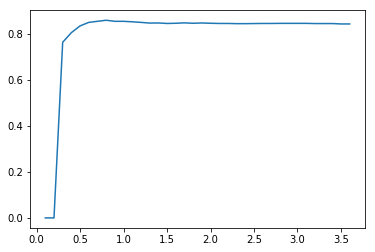

In [19]:
plt.plot(sigmas[:36],accuracies)
plt.show()

In [21]:
accuracies = []
rmses = []
thetas = []

for i in range(100): 
    theta_ = np.random.uniform(0.5,4,features.shape[1])
    if i % 10 == 0:
        print(i)
    dlp_wrbf = DeepLP_WeightedRBF.DeepLP_WeightedRBF(100, num_nodes, features, graph, sigma, theta_, 1, regularize=0)

    dlp_wrbf_prediction = np.rint(dlp_wrbf.labelprop(validation_data,theta_)).reshape(num_nodes)[unlabeled_indices]
    accuracy = utils.accuracy(solution, dlp_wrbf_prediction)
    rmse = utils.rmse(solution, dlp_wrbf_prediction)
    accuracies.append(accuracy)
    rmses.append(rmse)
  
    print(theta_)
    print(accuracy)

0
hi
[ 2.02628044  1.19450436  2.57404266  0.96248108  3.06456589  2.71033147
  2.46038856  1.94946962  3.00232759  3.42431212  1.84317861  3.48630929
  2.56762759  1.63096131  2.74101107  3.02932748  1.64176901  2.15518114
  3.49563196]
0.844491525424
hi
[ 1.63771657  1.80822701  3.92800206  1.64847068  1.1071544   2.33827566
  3.58681737  1.20495782  1.04006146  3.37578736  2.92288964  2.04798005
  3.06065114  1.43610955  2.09173424  0.59781255  0.82008608  1.71243731
  2.59884328]
0.841949152542
hi
[ 3.90943552  1.73965757  3.68955532  3.72284978  1.33334503  2.18024058
  3.2774972   1.67303502  1.01951588  3.47232145  3.08663811  3.01407815
  2.22722414  1.10678607  2.55053819  3.00973293  1.38884229  1.55755151
  3.83865509]
0.851271186441
hi
[ 2.28063716  3.37116237  3.19164961  3.87481998  1.92550923  2.33911803
  3.70932432  3.06925816  1.34350713  1.77447154  2.63138941  1.70803587
  3.41494771  1.73380821  1.20447592  2.31934395  3.93757738  2.82139935
  1.66842561]
0.8584745

KeyboardInterrupt: 

In [9]:
theta_df = pd.DataFrame(thetas)
accuracy_df = pd.DataFrame(accuracies)

theta_df.reset_index(drop=True, inplace=True)
accuracy_df.reset_index(drop=True, inplace=True)

df = pd.concat( [theta_df,accuracy_df], axis=1) 
df.columns = ['theta1','theta2','theta3','theta4','accuracy']

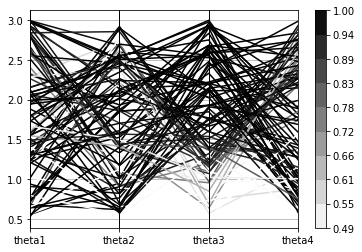

In [15]:
a = parallel_coordinates(df, 'accuracy', colormap="binary")